In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
train_data = datasets.ImageFolder(
    root="C:\\Users\\jasho\\OneDrive\\Desktop\\chest_xray\\train",
    transform=transform
)
val_data = datasets.ImageFolder(
    root="C:\\Users\\jasho\\OneDrive\\Desktop\\chest_xray\\val",
    transform=transform
)

print("Detected classes:", train_data.classes)  # ['NORMAL', 'PNEUMONIA']

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load and modify pretrained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with checkpointing
epochs = 25  # Increase for better results
best_accuracy = 0.0  # For tracking the best validation accuracy

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Training Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best model checkpoint
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model updated and saved with accuracy: {best_accuracy:.2f}%")

# Save final model
torch.save(model.state_dict(), "pneumonia_model.pth")
print("Final model saved as 'pneumonia_model.pth'")


Using device: cuda
Detected classes: ['NORMAL', 'PNEUMONIA']

Epoch 1/25
Training Loss: 0.1746
Validation Accuracy: 81.25%
Best model updated and saved with accuracy: 81.25%

Epoch 2/25
Training Loss: 0.0834
Validation Accuracy: 75.00%

Epoch 3/25
Training Loss: 0.0849
Validation Accuracy: 62.50%

Epoch 4/25
Training Loss: 0.0711
Validation Accuracy: 81.25%

Epoch 5/25
Training Loss: 0.0526
Validation Accuracy: 93.75%
Best model updated and saved with accuracy: 93.75%

Epoch 6/25
Training Loss: 0.0506
Validation Accuracy: 68.75%

Epoch 7/25
Training Loss: 0.0612
Validation Accuracy: 93.75%

Epoch 8/25
Training Loss: 0.0417
Validation Accuracy: 81.25%

Epoch 9/25
Training Loss: 0.0333
Validation Accuracy: 68.75%

Epoch 10/25
Training Loss: 0.0474
Validation Accuracy: 93.75%

Epoch 11/25
Training Loss: 0.0314
Validation Accuracy: 93.75%

Epoch 12/25
Training Loss: 0.0235
Validation Accuracy: 93.75%

Epoch 13/25
Training Loss: 0.0365
Validation Accuracy: 75.00%

Epoch 14/25
Training Loss:

  0%|          | 0/1000 [00:00<?, ?it/s]

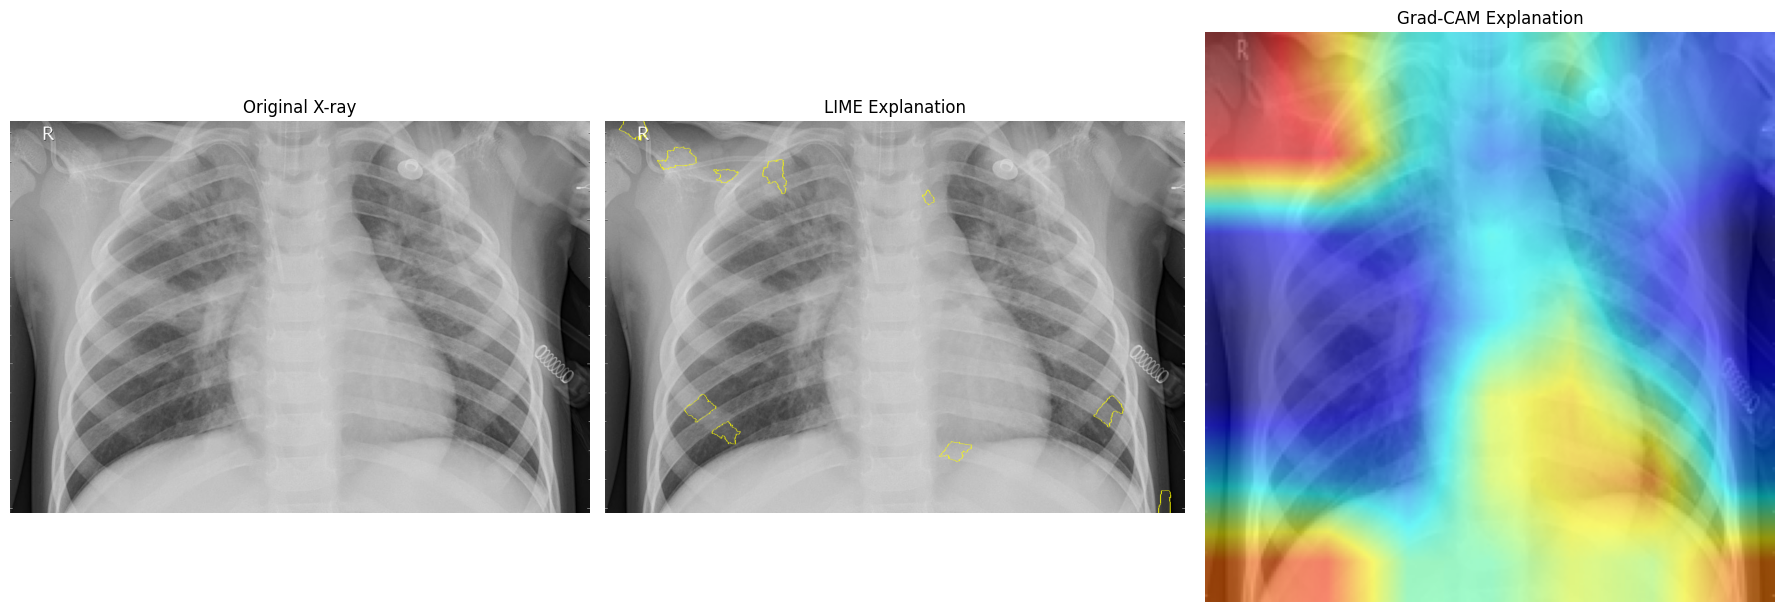

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torchvision.models as models
import torchvision.transforms as transforms

from lime import lime_image
from skimage.segmentation import mark_boundaries

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model architecture
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

# Load weights safely with weights_only=True
state_dict = torch.load("pneumonia_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image_path = "C:\\Users\\jasho\\OneDrive\\Desktop\\chest_xray\\test\\PNEUMONIA\\person3_virus_16.jpeg"
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0).to(device)

# Use fixed class for explanation (1 = Pneumonia, 0 = Normal)
predicted_class = 1

# --- LIME Explanation ---
def batch_predict(images_np):
    model.eval()
    batch = torch.stack([
        transform(Image.fromarray(img).convert("RGB")) for img in images_np
    ], dim=0).to(device)
    with torch.no_grad():
        logits = model(batch)
    return logits.cpu().numpy()

def get_lime_explanation(pil_img, target_class):
    explainer = lime_image.LimeImageExplainer()
    img_np = np.array(pil_img)
    explanation = explainer.explain_instance(
        img_np,
        batch_predict,
        labels=(target_class,),
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    lime_img, mask = explanation.get_image_and_mask(
        label=target_class,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    return lime_img, mask

# --- Grad-CAM Explanation ---
def get_gradcam_overlay(image_tensor, image_pil, target_class):
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(target_class)])[0]

    # Convert PIL image to float32 normalized numpy
    img_np = np.array(image_pil.resize((224, 224))).astype(np.float32) / 255.0
    if img_np.max() > 1.0:
        img_np = img_np / 255.0
    if img_np.shape[-1] == 4:
        img_np = img_np[..., :3]
    return show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# Generate explanations
lime_img, lime_mask = get_lime_explanation(image_pil, predicted_class)
gradcam_img = get_gradcam_overlay(input_tensor, image_pil, predicted_class)

# --- Display: Original + LIME + Grad-CAM ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original X-ray
axs[0].imshow(np.array(image_pil))
axs[0].set_title("Original X-ray")
axs[0].axis("off")

# LIME
axs[1].imshow(mark_boundaries(lime_img / 255.0, lime_mask))
axs[1].set_title("LIME Explanation")
axs[1].axis("off")

# Grad-CAM
axs[2].imshow(gradcam_img)
axs[2].set_title("Grad-CAM Explanation")
axs[2].axis("off")

plt.tight_layout()
plt.savefig("lime_gradcam_comparison.png")
plt.show()


In [5]:
import torch
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load trained model (safely)
state_dict = torch.load("pneumonia_model.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# Prediction Function
def predict_xray(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

    label = "Pneumonia" if prediction == 1 else "Normal"
    print(f"Prediction: {label}")
    return input_tensor, image, prediction

# Run prediction
test_image_path = "C:\\Users\\jasho\\OneDrive\\Desktop\\chest_xray\\test\\PNEUMONIA\\person3_virus_16.jpeg"
input_tensor, original_pil, predicted_class = predict_xray(test_image_path)


Prediction: Pneumonia
